# CIFAR-10 Luokitteluprojekti (FCN)


#### Data preparation

In [37]:
from keras.src.utils import to_categorical
import keras
from sklearn.model_selection import train_test_split


(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train.reshape(-1, 32 * 32 * 3)
X_test = X_test.reshape(-1, 32 * 32 * 3)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Add stronger normalization here
import numpy as np
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0) + 1e-7
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# Data for generator use
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Then convert labels to categorical format
y_train_split = to_categorical(y_train_split, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)



#y_train = to_categorical(y_train, 10)
#y_test = to_categorical(y_test, 10)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (50000, 3072)
Test data shape: (10000, 3072)


#### Modeling

In [38]:
from keras import backend as K
from keras import layers
from keras import regularizers

print(K.backend())

# Simple model ~50% accuracy
'''
inputs = keras.Input(shape=(3072,))
x = layers.Dense(256, activation="relu")(inputs)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10_model")
'''

# Wider and deeper FCN
inputs = keras.Input(shape=(3072,))
x = layers.Dense(1024, activation="relu", kernel_regularizer=regularizers.l2(0.0005))(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(10, activation="softmax")(x)
improved_model = keras.Model(inputs=inputs, outputs=outputs)

tensorflow


In [39]:
improved_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1024)           │     3,146,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,844,746 (14.67 MB)

 Trainable params: 3,840,906 (14.65 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [40]:
from keras_preprocessing.image import ImageDataGenerator

# Create data generator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Reshape for augmentation, then flatten for model
# This creates random variations of your training images by
# This is mostly for CNN model, but it might help FCN model to perform better
def generate_augmented_batches(X, y, batch_size=128):
    X_reshaped = X.reshape(-1, 32, 32, 3)
    gen = datagen.flow(X_reshaped, y, batch_size=batch_size)
    while True:
        X_batch, y_batch = gen.next()
        yield X_batch.reshape(-1, 3072), y_batch

In [41]:
# Learning rate schedule
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# Different optimizer configuration
improved_model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    metrics=["accuracy"],
)

# Early stop callback function
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.0001,
    restore_best_weights=True
)


# Reshape and flatten data
train_generator = generate_augmented_batches(X_train_split, y_train_split)

# Add the callbacks
history = improved_model.fit(
    train_generator,
    steps_per_epoch=len(X_train_split) // 128,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, lr_scheduler]
)


Epoch 1/100
312/312 ━━━━━━━━━━━━━━━━━━━━ 43s 128ms/step - accuracy: 0.2344 - loss: 3.6850 - val_accuracy: 0.3867 - val_loss: 3.0023 - learning_rate: 0.0100
Epoch 2/100
312/312 ━━━━━━━━━━━━━━━━━━━━ 41s 130ms/step - accuracy: 0.3404 - loss: 3.1081 - val_accuracy: 0.4251 - val_loss: 2.8292 - learning_rate: 0.0100
Epoch 3/100
312/312 ━━━━━━━━━━━━━━━━━━━━ 44s 140ms/step - accuracy: 0.3750 - loss: 2.9501 - val_accuracy: 0.4519 - val_loss: 2.7041 - learning_rate: 0.0100
Epoch 4/100
312/312 ━━━━━━━━━━━━━━━━━━━━ 46s 148ms/step - accuracy: 0.3938 - loss: 2.8442 - val_accuracy: 0.4675 - val_loss: 2.5975 - learning_rate: 0.0100
Epoch 5/100
312/312 ━━━━━━━━━━━━━━━━━━━━ 47s 152ms/step - accuracy: 0.4114 - loss: 2.7346 - val_accuracy: 0.4735 - val_loss: 2.5070 - learning_rate: 0.0100
Epoch 6/100
312/312 ━━━━━━━━━━━━━━━━━━━━ 46s 149ms/step - accuracy: 0.4183 - loss: 2.6573 - val_accuracy: 0.4869 - val_loss: 2.4323 - learning_rate: 0.0100
Epoch 7/100
312/312 ━━━━━━━━━━━━━━━━━━━━ 46s 147ms/step - accura

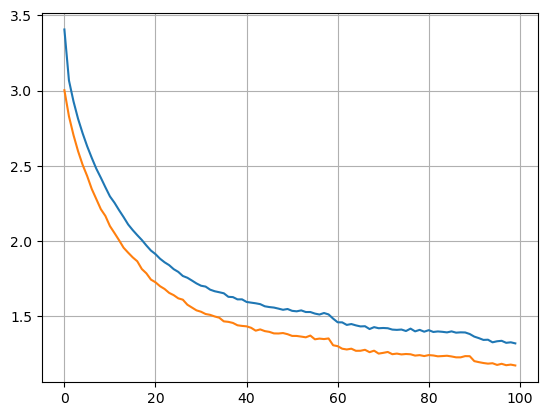

In [42]:
from matplotlib import pyplot as plt

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.grid()
plt.show()

In [43]:
test_scores = improved_model.evaluate(X_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

313/313 - 3s - 10ms/step - accuracy: 0.6250 - loss: 1.1805
Test loss: 1.1805211305618286
Test accuracy: 0.625


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9862154..1.5986629].


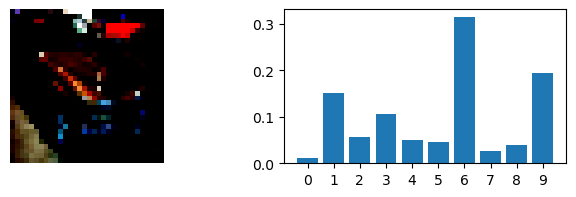

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8595604..2.073154].


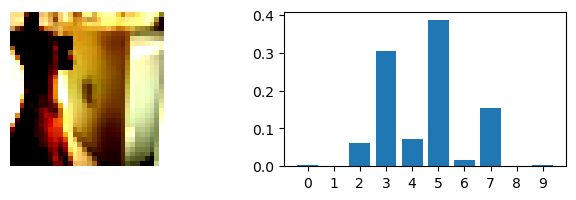

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1814191..1.6803493].


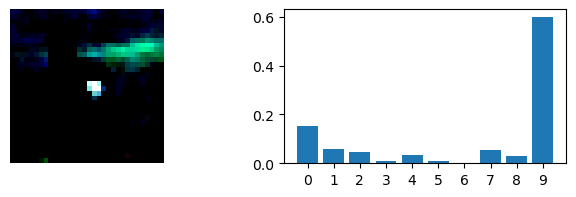

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7430602..1.6016728].


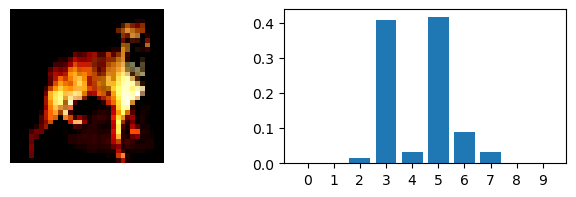

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0848246..2.6250987].


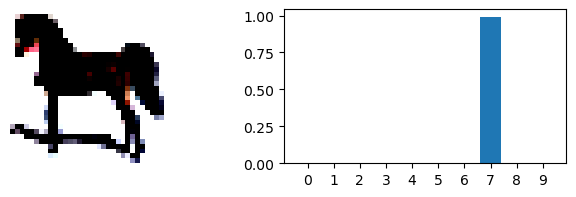

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6905259..2.2839038].


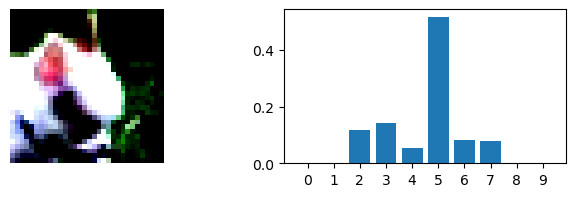

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8058779..1.9426829].


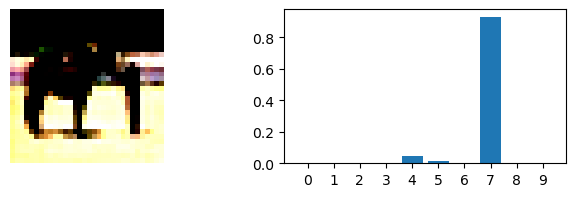

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9072556..2.0511596].


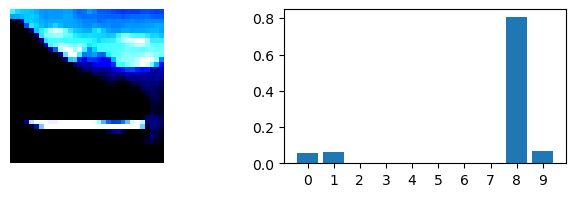

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.984687..2.4203954].


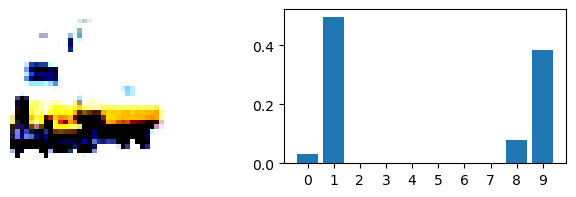

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7865912..2.5668976].


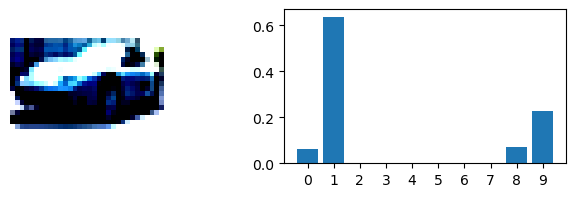

In [44]:
import numpy as np

start = 2000

for k in range(10):
    plt.figure(figsize=(8, 2))

    # Get one image
    x = np.expand_dims(X_test[start + k], axis=0)

    # Predict
    y = improved_model.predict(x)[0]

    # Show the image
    plt.subplot(1, 2, 1)
    plt.imshow(X_test[start + k].reshape(32, 32, 3))
    plt.axis("off")

    # Show the prediction probabilities
    plt.subplot(1, 2, 2)
    plt.bar(np.arange(10), y)
    plt.xticks(range(10))

    plt.show()
